# Topic Modelling - LDA

In [2]:
ytfile = 'Youtube_combined_Final.json'
ytFile = 'Youtube_combined_Final.json'

In [3]:
! pip install langdetect

In [4]:
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0  

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False


In [5]:
#all the codes from this file are retrieved from Social Media and Network Analytics, Lab Notes 

import json
import pandas as pd
from nltk import ngrams
from collections import Counter
import nltk
import string
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
import numpy as np
import math
import pyLDAvis
import pyLDAvis.lda_model
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

# Clening processes
tweetTokeniser = nltk.tokenize.TweetTokenizer()
lPunct = list(string.punctuation)
lStopwords = nltk.corpus.stopwords.words('english') + lPunct + ['rt', 'via', '..', '...', '"', "'", '`', '’', 'http', 'https','com', 'www', 'co', 'amp','could', 'would','giphy']

tweetLemmatizer = nltk.stem.WordNetLemmatizer()

lTitles = []  
lComments = []  
lCombined = []

def processText(text, tweetTokeniser, tweetLemmatizer, lStopwords):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  
    tokens = tweetTokeniser.tokenize(text.lower())     
    return [tweetLemmatizer.lemmatize(token) for token in tokens if token not in lStopwords and not token.isdigit()]


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nadiatoo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
with open(ytFile, 'r', encoding='utf-8') as f:
    ytDump = json.load(f)

for video in ytDump:
    # Process video title
    title_text = video.get('Title', '')
    if not is_english(title_text):
        continue
    title_text = re.sub(u"(\u2018|\u2019|\u2014)", "", title_text)
    lTokens_title = processText(title_text, tweetTokeniser, tweetLemmatizer, lStopwords)
    lTitles.append(' '.join(lTokens_title))

    # Process all comments (flat list)
    all_comment_tokens = []
    for comment in video.get('Comments', []):
        comment_text = comment.get('text', '')
        if not is_english(comment_text):
            continue
        comment_text = re.sub(u"(\u2018|\u2019|\u2014)", "", comment_text)
        tokens = processText(comment_text, tweetTokeniser, tweetLemmatizer, lStopwords)
        all_comment_tokens.extend(tokens)
    
    lComments.append(' '.join(all_comment_tokens))

    # Combine title + comments tokens
    combined_tokens = lTokens_title + all_comment_tokens
    lCombined.append(' '.join(combined_tokens))


In [7]:
# Manully choose the optimal number
topicNum = 9
wordNumToDisplay = 8
featureNum = 3000

In [8]:
tfVectorizer = CountVectorizer(
    max_df=0.5,    
    min_df=1,       
    stop_words='english',
    max_features=featureNum
)


tf = tfVectorizer.fit_transform(lCombined)

tfFeatureNames = tfVectorizer.get_feature_names_out()

ldaModel = LatentDirichletAllocation(n_components =topicNum, max_iter=10, learning_method='online').fit(tf)

In [9]:
def display_topics(model, featureNames, numTopWords):
    """
    Prints out the most associated words for each feature.

    @param model: lda model.
    @param featureNames: list of strings, representing the list of features/words.
    @param numTopWords: number of words to print per topic.
    """

    for topicId, lTopicDist in enumerate(model.components_):
        print("Topic %d:" % (topicId))
        print(" ".join([featureNames[i] for i in lTopicDist.argsort()[:-numTopWords - 1:-1]]))

In [10]:
display_topics(ldaModel, tfFeatureNames, wordNumToDisplay)

Topic 0:
twerk august sabra 80k tengo mucha museum 70k
Topic 1:
amala utopia synopsis utopian twerk socialist fuck porno
Topic 2:
amala august twerk utopia tengo 85k museum 80k
Topic 3:
amala utopia synopsis utopian socialist fuck arrow recap
Topic 4:
mitch twerk amala 80k mucha cgied tyla august
Topic 5:
twerk amala august 80k facebook tengo museum sabra
Topic 6:
twerk august sabra 70k 80k mucha mitch museum
Topic 7:
mitch 6k farquaadette okubo gall shittiest bitten sakurako
Topic 8:
amala utopia utopian socialist synopsis twerk fuck arrow


In [11]:
panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=36789) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=36789) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=36789) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=36789) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarnin

# Wordcloud

In [13]:
def displayWordcloud(model, featureNames):
    """
    Displays the word cloud of the topic distributions, stored in model.

    @param model: lda model.
    @param featureNames: list of strings, representing the list of features/words.
    """
    normalisedComponents = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]

    numTopics = len(model.components_)
    plotCols = 4
    plotRows = int(math.ceil(numTopics / plotCols))
    
    topicNum = len(model.components_)

    plotColNum = 3

    plotRowNum = int(math.ceil(topicNum / plotColNum))
    plt.figure(figsize=(plotCols * 5, plotRows * 4))

    for topicId, lTopicDist in enumerate(normalisedComponents):
        lWordProb = {featureNames[i] : wordProb for i,wordProb in enumerate(lTopicDist)}
        wordcloud = WordCloud(background_color='black')
        wordcloud.fit_words(frequencies=lWordProb)
        plt.subplot(plotRowNum, plotColNum, topicId+1)
        plt.title('Topic %d:' % (topicId+1))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")

    plt.show(block=True)


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


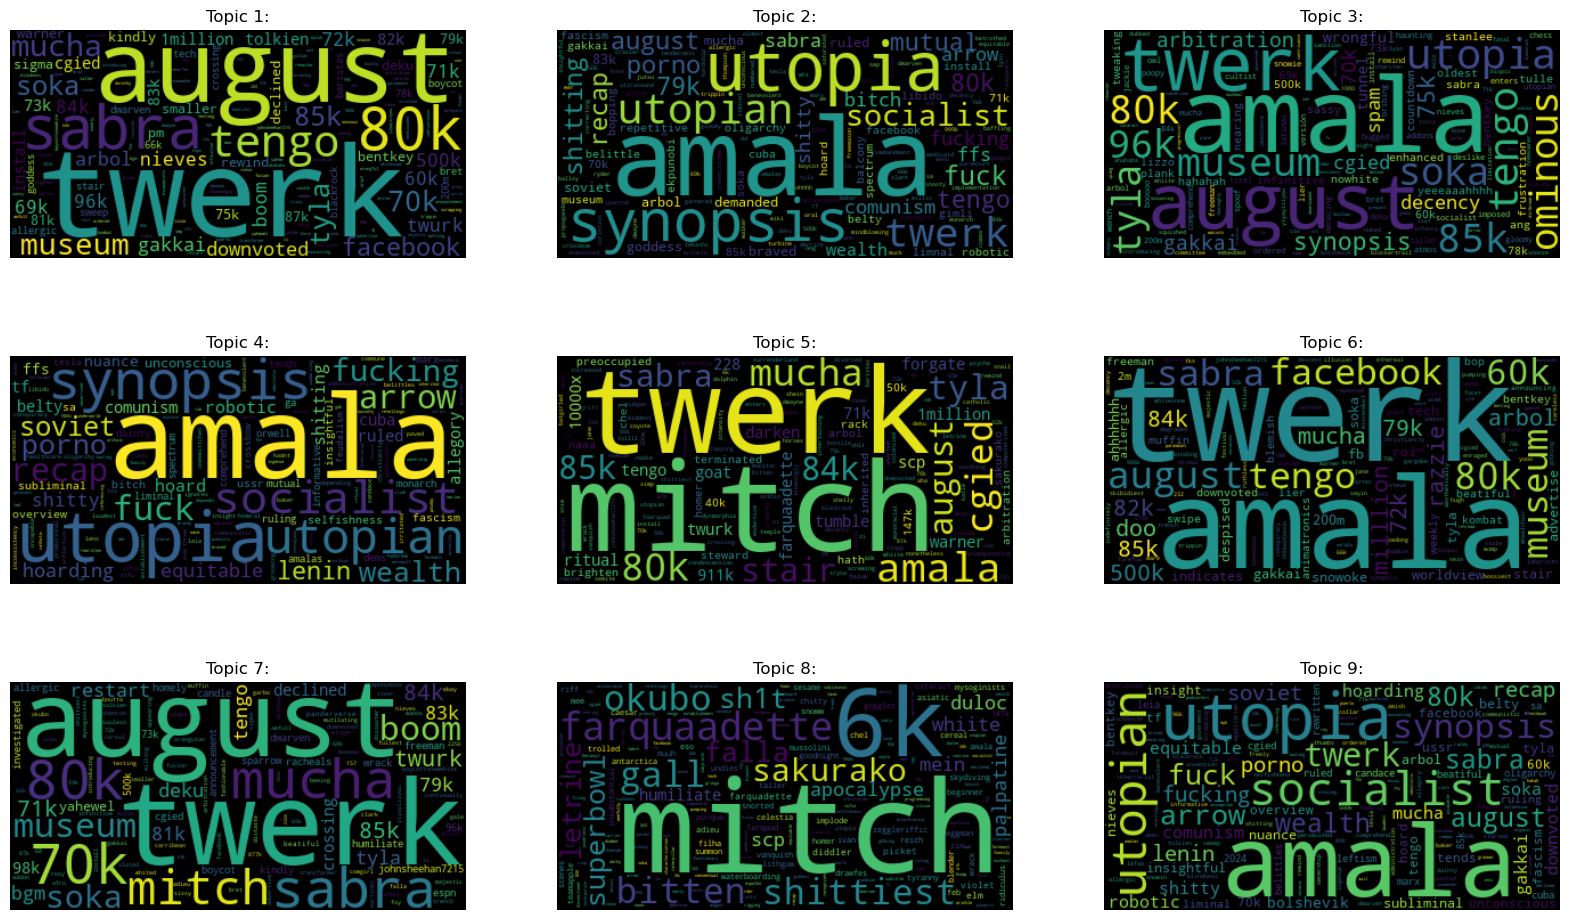

In [14]:
displayWordcloud(ldaModel, tfFeatureNames)